# Introduction and Overview
This notebook contains the machine learning pipeline used for the article "How Big is the Media Multiplier? Evidence from Dyadic News Data" by Timothy Besley, Thiemo Fetzer, and Hannes Mueller. 

It is designed to classify news articles based on violence content, focusing on Israel, Morocco, Tunisia, Turkey, and Egypt. The pipeline includes data preprocessing, model training, and out-of-sample testing with a case study on Sri Lanka. This overview serves as a guide through the various components of the code.

### Imports and Setup:
In this section we set up the needed packages and functions used for pre-processing and visualizing performance.
### Loading Data and Data Preprocessing:
We clean the text data and pre-process it minimally tokenizing and lowercasing. Importantly we exclude articles in which our destination countries condemn violence elsewhere as this would lead to measurement error in the output data. Part of pre-processing is to add the title tokens four times to the text tokens when producing the document term matrix for the supervised learning. This idea is taken from the pipeline in Cage et al (2019) The Production of Information in an Online World.
### Apply Dictionary Method:
Dictionary methods are standard in economics. We apply different variants of dictionaries and their interactions pick the best performing one to compare to the performance of the supervised machine learning pipeline.
### Model Training: 
Training of 3 classifiers for 3 labels. This is the longest part of the code. We conduct crossval gridsearches for all 9 classifiers. We then build one ensemble classifier for each label by doing simple average across the random forest, naive bayes and xgb classifier. For label_2 we train the entire pipeline, build the ensemble check the output and relabel manually as we realize some of the manual labeling is wrong. This makes the code somewhat cumbersome.
### Application of Classifiers to Larger Corpus:
We have trained three ensemble classifiers on all available training labels. We now use the trained classifiers out-of-sample on our corpus of over 500,000 news articles. The result are 9 continuous scores (three for each label) which we carry to the post-processing. As in the pipeline we take the average of the three classifiers to produce a score in post-processing.

### Out-of-Sample Testing (Sri Lanka Case Study):
Given the supervised learning set-up here, we do not expect the trained algorithm to detect violence against tourists well in other countries. If we were to train a generalizing algorithm we would, for example, filter out country- and location-specific vocabulary first. A simple Tf-idf at the country level would be an attractive and simple way to do this. 

However, it is interesting to see whether our ensembles generalize somewhat. Sri Lanka is a good country to check our algorithm because it is far away from the training sample and had a vicious, out-of-the-blue, terror attack on tourists in April 2019. The pipeline below applies our three classifiers to news text from Sri Lanka. The average ensemble score for each month is shown in the paper. The algorithm clearly picks up the attack remarkably well with scores shooting up in the month of the attack and then decreasing again as the discussion of the attack declines again. 

Questions and suggestions please to h.mueller.uni@gmail.com

Important note: results shown below may deviate slightly from the paper version as not all randomness was elininated by setting the random seed.



# Imports and Setup
In this section, we import necessary Python libraries and set up configurations crucial for our analysis. Libraries like Pandas and NumPy are used for data handling, NLTK for natural language processing, and Scikit-learn for machine learning tasks. Initial configurations include setting up paths and preparing text preprocessing functions, essential for later stages of the pipeline.

We also set-up 5 functions. The two first functions help in the text pre-processing and the latter three are used to visualize performance.


In [1]:
import pandas as pd
import numpy as np
import csv
import nltk
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer 
# download the following packages if needed

#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('stopwords')

from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score


from sklearn.model_selection import cross_val_predict

import os

import re



from tqdm import tqdm
tqdm.pandas()


#getting a library of stopwords and defining a lemmatizer
porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

#set paths for input and output
path='C:\\Dropbox\\Lucy and Diveena\\Data coding project'

spitout='C:\\Dropbox\\Violence and Tourism\\Replication\\03 Paper\\figures\\'
dataspitout='C:\\Dropbox\\Violence and Tourism\\Replication\\02 Code\\00_ML\\'


#spitout='C:\\Dropbox\\Violence and Tourism\\Replication\\03 Paper\\figures\\'


#additional functions

#the following leaves in place two or more capital letters in a row
#will be ignored when using standard stemming
def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

#modular pipeline for stemming, lemmatizing and lowercasing
def tokenize(text, modulation):
    tokens = re.split(r'\W+', text)
    stems = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        lowers=abbr_or_lower(token)
        if lowers not in stop_words:
            if re.search('[a-zA-Z]', lowers):
                if modulation==1:
                    stems.append(porter.stem(lowers))
                if modulation==2:
                    stems.append(lmtzr.lemmatize(lowers))
                if modulation==0:
                    stems.append(lowers)
                stems.append(" ")
    return "".join(stems)

#Functions to make figures and save them
def draw_precision_curve(y,x,name):
    precision, recall, thresholds = precision_recall_curve(y, x)
    avprec=average_precision_score(y, x)

    plt.plot(recall, precision, lw=5, label='Av.Precision = %0.2f)' % (avprec))

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision/Recall Curve')
    plt.legend(loc="lower left")
    plt.savefig(spitout+name+'.pdf')
    plt.show()

def draw_roc_curve(y,x,name):
    fpr, tpr, thresholds = roc_curve(y,x)
    roc_auc = auc(fpr, tpr)


    plt.plot(fpr,tpr, lw=5, label='AUC = %0.2f)' % (roc_auc))

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower left")
    plt.savefig(spitout+name+'.pdf')
    plt.show()
    
    
def separation_plot(pdata, fname, alpha=1):
    '''
    Display observed events against predicted probabilities for binary classification problems
    Arguments
    ---------
        y_true : vector of observed class labels
        y_pred : vector of predicted probabilities
        fname: file path to directory to save plot 
        alpha: float from 0 to 1, transparency of indicators of observed events
    '''
    #normalization
    pdata=(pdata-pdata.min())/(pdata.max()-pdata.min())
    
    #wrangling
    pdata.columns = ['y', 'yhat']
    pdata = pdata.sort_values('yhat')
    pdata = pdata.reset_index(drop=True)

    events = pdata[pdata['y'] == 1]

    evals = events.index.values


    plt.figure(figsize=(20, 5))
    plt.ylabel('Predicted Score')
    ax = plt.gca()
    ax.set_xlim([1, (evals[-1] + 1)])
    ax.set_ylim([0, 1])
    

    rr = 0
    for i in evals:
        if rr == 0:
            ax.axvline(x=i, linewidth=0.2, linestyle='-', color='k', alpha=alpha, label = 'True Positives', zorder=2)
            rr = 1
        else:
            ax.axvline(x=i, linewidth=0.2, linestyle='-', color='k', alpha=alpha, zorder=1)
    
    ax.plot(pdata['yhat'], linestyle='--', color='red', lw = 4, label = 'Predicted Score', zorder=3)
    ax.set_xlabel('Rank of prediction')
    ax.legend(loc="upper left")
    plt.savefig(fname)
    plt.show()
    plt.close() 

# Data Loading and Data Preprocessing

We have two sets of data as we obtained additional text data at a later stage and decided to keep them seperately. In this section we pre-process everything in parallel to have similar document term matrixes. The mode mod=2 sets the pre-processing function used to only lemmatizing. 

We first load the data that contains the labelled articles. This data contains: 249905 articles, 35346 labels for label_0 and 24412 labels for label_1, label_2 and label_3. We then load the the second part of the corpus which contains 262,854 articles and no labels.

We exclude our 5 destination coutnries condemning violence elsewhere as this is misleading about violence in these countries.



In [2]:
#loading the data

filename ="extended_data_train.csv"
corpus_data = pd.read_csv(os.path.join(path, filename), sep=',', encoding='utf-8')
corpus_data.info()


mod=0 #=1 means stemming, =2 means lemmatizing, =0 just lowercase
#pre-process title
tit_preproc = (
    corpus_data.TITLE_EN
    .astype(str)
    .progress_apply(lambda row: tokenize(row, mod))
)

corpus_data["titles_lemm"]=tit_preproc

#pre-process text
text_preproc = (
    corpus_data.TXT_EN
    .astype(str)
    .progress_apply(lambda row: tokenize(row, mod))
)

corpus_data["text_with_head_lemm"]=text_preproc

print("done with text plus titles")

corpus_data = corpus_data.dropna(subset=['titles_lemm']).reset_index(drop=True)

corpus_data  = corpus_data[['ARTICLENUMID','issuing_iso3c','dest_iso3c', 'year','monthnum','day', 'TITLE_EN','text_with_head_lemm'
                            , 'titles_lemm', 'label_0','label_1','label_2','label_3', 'LENGTH']]


        
#second dataset
path_test='C:\\Dropbox\\Lucy and Diveena\\Google Translate'
filename_test ="FACTIVA.TRANS.v2.csv"

test_data = pd.read_csv(os.path.join(path_test, filename_test), sep=',', encoding='utf-8')

test_data.rename(columns = {'ID':'ARTICLENUMID'}, inplace = True)
test_data.rename(columns = {'TRANSLATED_SD':'TXT_EN'}, inplace = True)
test_data.rename(columns = {'HEADLINE_TRANSLATED':'TITLE_EN'}, inplace = True)
test_data['label_0'] = np.nan
test_data['label_1'] = np.nan
test_data['label_2'] = np.nan
test_data['label_3'] = np.nan

test_data=test_data.dropna(subset=['TITLE_EN'])

test_data=test_data.reset_index()

test_data['day']=test_data.date.str[-2:]

test_data.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249905 entries, 0 to 249904
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     249905 non-null  int64  
 1   ARTICLENUMID   249905 non-null  object 
 2   LOADDATE       249905 non-null  object 
 3   LENGTH         249905 non-null  object 
 4   year           249900 non-null  float64
 5   day            216617 non-null  float64
 6   monthnum       249900 non-null  float64
 7   issuing_iso3c  249905 non-null  object 
 8   dest_iso3c     249905 non-null  object 
 9   LANGUAGE_SD    249905 non-null  object 
 10  TXT_EN         249905 non-null  object 
 11  GTD_EVETDATE   47781 non-null   object 
 12  GTD_NKILL      47781 non-null   float64
 13  GTD_EVENTID    47781 non-null   float64
 14  label_0        35346 non-null   float64
 15  label_1        24412 non-null   float64
 16  label_2        24412 non-null   float64
 17  label_3        24412 non-null

100%|█████████████████████████████████████████████████████████████████████████| 249905/249905 [04:38<00:00, 896.73it/s]


done with text plus titles
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262854 entries, 0 to 262853
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   index          262854 non-null  int64  
 1   ARTICLENUMID   262854 non-null  object 
 2   DATE           262854 non-null  object 
 3   LENGTH         262854 non-null  object 
 4   LANG           262854 non-null  object 
 5   HEADLINE       262432 non-null  object 
 6   CONTENT        262853 non-null  object 
 7   ff             262854 non-null  object 
 8   CONTENT_CLEAN  262853 non-null  object 
 9   DYAD           262397 non-null  object 
 10  issuing_iso3c  262397 non-null  object 
 11  dest_iso3c     262397 non-null  object 
 12  TXT_EN         262835 non-null  object 
 13  TITLE_EN       262854 non-null  object 
 14  date           262854 non-null  object 
 15  year           262854 non-null  int64  
 16  monthnum       262854 non-null  int64  
 17  la

In [3]:

lmtzr = WordNetLemmatizer()
new_stopwords = set(stopwords.words('english'))

mod=0 #=1 means stemming, =2 means lemmatizing, =0 just lowercase

#pre-process title
tit_preproc = (
    test_data.TITLE_EN
    .astype(str)
    .progress_apply(lambda row: tokenize(row, mod))
)

test_data["titles_lemm"]=tit_preproc

#pre-process text
text_preproc = (
    test_data.TXT_EN
    .astype(str)
    .progress_apply(lambda row: tokenize(row, mod))
)

test_data["text_with_head_lemm"]=text_preproc

print("done with text plus titles")

test_data = test_data.dropna(subset=['titles_lemm']).reset_index(drop=True)

test_data  = test_data[['ARTICLENUMID','issuing_iso3c','dest_iso3c', 'year','monthnum','day', 'TITLE_EN','text_with_head_lemm'
                        , 'titles_lemm','label_0','label_1','label_2','label_3', 'LENGTH']]

test_data.to_csv('test_beforemerge_test.csv',sep=',',encoding='utf-8')

full_data = pd.concat([corpus_data,test_data], join = "inner")
full_data.reset_index()
full_data.info()
full_data.to_csv('test_lemmatized_test.csv',sep=',',encoding='utf-8')
del test_data
del corpus_data

100%|████████████████████████████████████████████████████████████████████████| 262854/262854 [03:33<00:00, 1228.76it/s]


done with text plus titles
<class 'pandas.core.frame.DataFrame'>
Int64Index: 512759 entries, 0 to 262853
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ARTICLENUMID         512759 non-null  object 
 1   issuing_iso3c        512302 non-null  object 
 2   dest_iso3c           512302 non-null  object 
 3   year                 512754 non-null  float64
 4   monthnum             512754 non-null  float64
 5   day                  479471 non-null  object 
 6   TITLE_EN             512759 non-null  object 
 7   text_with_head_lemm  512759 non-null  object 
 8   titles_lemm          512759 non-null  object 
 9   label_0              35346 non-null   float64
 10  label_1              24412 non-null   float64
 11  label_2              24412 non-null   float64
 12  label_3              24412 non-null   float64
 13  LENGTH               512759 non-null  object 
dtypes: float64(6), object(8)
memory usage: 58

In [4]:
full_data.label_1.value_counts()

0.0    19589
1.0     4823
Name: label_1, dtype: int64

In [5]:
import pandas as pd
import numpy as np
import csv
import re

import xgboost as xgb

from pprint import pprint
from time import time
import logging

import nltk                                                             # Natural language Toolkit
from nltk.stem import SnowballStemmer                                   # Porter's II Stemmer
from nltk import word_tokenize                                          # Document tokenizer
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer

from matplotlib import pyplot as plt

from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn import tree

import os

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

from tqdm import tqdm
tqdm.pandas()

from collections import Counter



# uploading the data
filename ="test_lemmatized_test.csv"

# uploading the data
full_data = pd.read_csv(os.path.join(dataspitout, filename), sep=',', encoding='utf-8')
full_data.info()

full_data['titles_lemm'] = full_data['titles_lemm'].astype(str)
full_data['text_with_head_lemm'] = full_data['text_with_head_lemm'].astype(str)
#four times title following Cage
full_data['title_text']=full_data['text_with_head_lemm']+full_data['titles_lemm']+full_data['titles_lemm']+full_data['titles_lemm']+full_data['titles_lemm']





C:\Users\HMueller\anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512759 entries, 0 to 512758
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           512759 non-null  int64  
 1   ARTICLENUMID         512759 non-null  object 
 2   issuing_iso3c        512302 non-null  object 
 3   dest_iso3c           512302 non-null  object 
 4   year                 512754 non-null  float64
 5   monthnum             512754 non-null  float64
 6   day                  479471 non-null  float64
 7   TITLE_EN             512759 non-null  object 
 8   text_with_head_lemm  512747 non-null  object 
 9   titles_lemm          511619 non-null  object 
 10  label_0              35346 non-null   float64
 11  label_1              24412 non-null   float64
 12  label_2              24412 non-null   float64
 13  label_3              24412 non-null   float64
 14  LENGTH               512759 non-null  object 
dtypes: float64(7), in

In [6]:
#countries condemning violence elsewhere
searchstrings=['turkey condemns', 'egypt condemns', 'tunisia condemns', 'israel condemns', 'morocco condemns']
Tlist=[]
for s in full_data.titles_lemm:
    r = re.compile("|".join(r"\b%s\b" % w for w in searchstrings))
    wordcount = Counter(re.findall(r, s))
    #if sum(wordcount.values())>0:
    #    print(s)
    Tlist.append(sum(wordcount.values()))
full_data['condemns']=Tlist
full_data['condemns'].value_counts()


0    511725
1      1034
Name: condemns, dtype: int64

In [7]:
#use dictionary to filter destinations

searchstrings=["tunisia", "tunisian","tunisians", "tunis","sousse", "Tunisia", "Tunisian","TUNISIA"]
Tlist=[]
Length=[]
for s in full_data.title_text:
    r = re.compile("|".join(r"\b%s\b" % w for w in searchstrings))
    wordcount = Counter(re.findall(r, s))
    Tlist.append(sum(wordcount.values()))
    Length.append(len(s))
full_data['tunisia_count']=Tlist

searchstrings=["egypt", "egyptian","egyptians", "cairo", "sinai", "Egypt", "Egyptian","EGYPT","CAIRO", "hurghada","mubarak"]
Tlist=[]
Length=[]
for s in full_data.title_text:
    r = re.compile("|".join(r"\b%s\b" % w for w in searchstrings))
    wordcount = Counter(re.findall(r, s))
    Tlist.append(sum(wordcount.values()))
    Length.append(len(s))
full_data['egypt_count']=Tlist

searchstrings=["gaza","palestinian","palestine", "israel", "israelian","israelis","jerusalem","israeli", "netanyahu", "tel aviv", "sinai","bethlehem", "Israel", "Israelian","ISRAEL"]
Tlist=[]
Length=[]
for s in full_data.title_text:
    r = re.compile("|".join(r"\b%s\b" % w for w in searchstrings))
    wordcount = Counter(re.findall(r, s))
    Tlist.append(sum(wordcount.values()))
    Length.append(len(s))
full_data['israel_count']=Tlist

searchstrings=["turkey", "turkish","turks","istanbul","ankara","erdogan" "Turkey", "Turkish","TURKEY"]
Tlist=[]
Length=[]
for s in full_data.title_text:
    r = re.compile("|".join(r"\b%s\b" % w for w in searchstrings))
    wordcount = Counter(re.findall(r, s))
    Tlist.append(sum(wordcount.values()))
    Length.append(len(s))
full_data['turkey_count']=Tlist

searchstrings=["morocco", "moroccan", "moroccans","rabat","Morocco", "Moroccan", "marrakesh", "MOROCCO"]
Tlist=[]
Length=[]
for s in full_data.title_text:
    r = re.compile("|".join(r"\b%s\b" % w for w in searchstrings))
    wordcount = Counter(re.findall(r, s))
    Tlist.append(sum(wordcount.values()))
    Length.append(len(s))
full_data['morocco_count']=Tlist

full_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512759 entries, 0 to 512758
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           512759 non-null  int64  
 1   ARTICLENUMID         512759 non-null  object 
 2   issuing_iso3c        512302 non-null  object 
 3   dest_iso3c           512302 non-null  object 
 4   year                 512754 non-null  float64
 5   monthnum             512754 non-null  float64
 6   day                  479471 non-null  float64
 7   TITLE_EN             512759 non-null  object 
 8   text_with_head_lemm  512759 non-null  object 
 9   titles_lemm          512759 non-null  object 
 10  label_0              35346 non-null   float64
 11  label_1              24412 non-null   float64
 12  label_2              24412 non-null   float64
 13  label_3              24412 non-null   float64
 14  LENGTH               512759 non-null  object 
 15  title_text       

for text in full_data[(full_data["morocco_count"]==0)&(full_data["dest_iso3c"]=="MAR")].title_text:
    print(text)
    print("   ")

for text in full_data[(full_data["turkey_count"]==0)&(full_data["dest_iso3c"]=="TUR")].title_text:
    print(text)
    print("   ")

for text in full_data[(full_data["israel_count"]==0)&(full_data["dest_iso3c"]=="ISR")].title_text:
    print(text)
    print("   ")

for text in full_data[(full_data["egypt_count"]==0)&(full_data["dest_iso3c"]=="EGY")].title_text:
    print(text)
    print("   ")

for text in full_data[(full_data["tunisia_count"]==0)&(full_data["dest_iso3c"]=="TUN")].title_text:
    print(text)
    print("   ")

In [8]:
full_data=full_data[((full_data["israel_count"]>0)&(full_data["dest_iso3c"]=="ISR")) |
          ((full_data["morocco_count"]>0)&(full_data["dest_iso3c"]=="MAR")) |
          ((full_data["turkey_count"]>0)&(full_data["dest_iso3c"]=="TUR")) |
          ((full_data["tunisia_count"]>0)&(full_data["dest_iso3c"]=="TUN")) |
          ((full_data["egypt_count"]>0)&(full_data["dest_iso3c"]=="EGY"))]

The following code collects all data and does additional label engineering as label_0=0 implies that there was no violence which is knowledge that can be used to deduce that the other levels of violence also must have been 0.

In [9]:
data_train = full_data[pd.notna(full_data.label_0)].reset_index()
data_train  = data_train[['issuing_iso3c','dest_iso3c', 'year','monthnum','day', 'title_text', 'text_with_head_lemm', 'titles_lemm','label_0','label_1','label_2','label_3']]

#if label 0 is 0 the likelihood that the other two are 0 is overwhelming. Therefore carry over 0 coding.
data_train["label_1"][(data_train.label_1.isna())&(data_train.label_0==0)]=0
data_train["label_2"][(data_train.label_2.isna())&(data_train.label_0==0)]=0
data_train["label_3"][(data_train.label_3.isna())&(data_train.label_0==0)]=0

data_train.info()

#start training
#label_3 are not used as it turned out to be too specific (fata violence of tourists).
#this do file will therefore only use label_0, label_1 and label_2


labels_0 = data_train.label_0.tolist()
labels_1 = data_train.label_1.tolist()
labels_2 = data_train.label_2.tolist()
labels_3 = data_train.label_3.tolist()
Titles = data_train.titles_lemm.tolist()
Texts = data_train.text_with_head_lemm.tolist()
Fourtit_text=data_train.title_text.tolist()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35233 entries, 0 to 35232
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   issuing_iso3c        35233 non-null  object 
 1   dest_iso3c           35233 non-null  object 
 2   year                 35233 non-null  float64
 3   monthnum             35233 non-null  float64
 4   day                  35233 non-null  float64
 5   title_text           35233 non-null  object 
 6   text_with_head_lemm  35233 non-null  object 
 7   titles_lemm          35233 non-null  object 
 8   label_0              35233 non-null  float64
 9   label_1              35233 non-null  float64
 10  label_2              35233 non-null  float64
 11  label_3              35233 non-null  float64
dtypes: float64(7), object(5)
memory usage: 3.2+ MB


# Apply Dictionary Method

We implemented a simple dictionary method for spotting fatal violence and harm to tourist in news articles. This serves more to illustrate the advantages and limits of the method than a serious attempt to develop the perfect dictionary. 

But our dictionary method also not a straw man - we spent considerable time trying different features and combining them in additive and multiplicative ways. More specifically, we followed the intuition that a tourist harm index should follow a multiplicative logic of tourist*harm and tried to implement this logic in two different ways: 1) we used lists of bigrams that contain both the word tourist and some word indicating harm 2) we made counts of both and multiplied them.

At the end we realized that an additive index performs better and therefore simply added monograms and bigrams across lists up to generate the index shown in the paper.


In [10]:

#Tourist harm method one: bigrams
searchstrings=["attack tourist", "attacked tourist","kill tourist","killed tourist","killing tourist","massacre tourist",
               "massacred tourist","tourist attack","tourist killed","tourist kidnapped","tourist wounded",
               "attack tourists", "attacked tourists","kill tourists","killed tourists","killing tourists","massacre tourists",
               "massacred tourists","tourists attack","tourists killed","tourists kidnapped","tourists wounded"]
Tlist=[]
Length=[]
for s in data_train.title_text:
    r = re.compile("|".join(r"\b%s\b" % w for w in searchstrings))
    wordcount = Counter(re.findall(r, s))
    Tlist.append(sum(wordcount.values()))
    Length.append(len(s))
data_train['T_H_count']=Tlist
data_train['alength']=Length

data_train['T_H_count'].value_counts() 

#Tourist harm method one: two lists of monograms
searchstrings=["attack", "attacked", "kill", "killed", "murder", "murdered", "massacre","massacred", "kidnap",
               "kidnapped", "injur", "injured", "wound", "wounded", "terror"]
Hlist=[]
Length=[]
for s in data_train.title_text:
    r = re.compile("|".join(r"\b%s\b" % w for w in searchstrings))
    wordcount = Counter(re.findall(r, s))
    Hlist.append(sum(wordcount.values()))
data_train['H_count']=Hlist

searchstrings=["tourist", "tourists"]
Tlist=[]
Length=[]
for s in data_train.title_text:
    r = re.compile("|".join(r"\b%s\b" % w for w in searchstrings))
    wordcount = Counter(re.findall(r, s))
    Tlist.append(sum(wordcount.values()))
data_train['T_count']=Tlist

#violence list
searchstrings=["fatality", "kill", "killed", "massacred", "murdered", "violence", "violent","attack",
               "attacked","injur", "injured", "hit","death","dead"]
Klist=[]
Length=[]
for s in data_train.title_text:
    r = re.compile("|".join(r"\b%s\b" % w for w in searchstrings))
    wordcount = Counter(re.findall(r, s))
    Klist.append(sum(wordcount.values()))
data_train['K_count']=Klist

#We tried relative counts as well but this always makes things worse
data_train['tourist_harm_1']=data_train['T_H_count']
data_train['tourist_harm_2']=(data_train['T_count']+data_train['H_count']+data_train['T_H_count'])
data_train['fatal_harm']=data_train['K_count']



In [11]:
#AUC performance
print("Score reached with dictionary method on fatalities:", roc_auc_score(labels_1, data_train['fatal_harm']))
print("Score reached with dictionary method 1 on tourist violence:", roc_auc_score(labels_2, data_train['tourist_harm_1']))
print("Score reached with dictionary method 2 on tourist violence:", roc_auc_score(labels_2, data_train['tourist_harm_2']))

Score reached with dictionary method on fatalities: 0.890786563860838
Score reached with dictionary method 1 on tourist violence: 0.6309132737668383
Score reached with dictionary method 2 on tourist violence: 0.9014261947048524


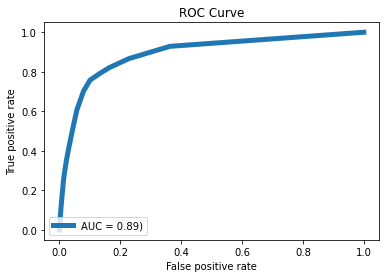

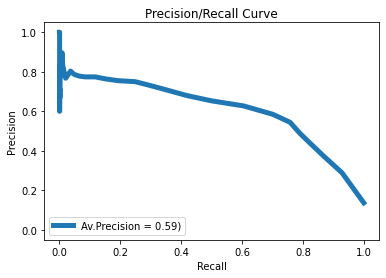

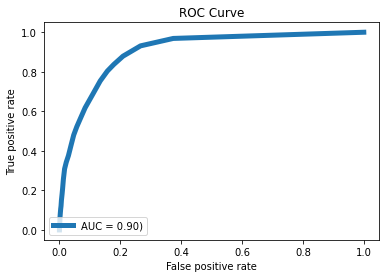

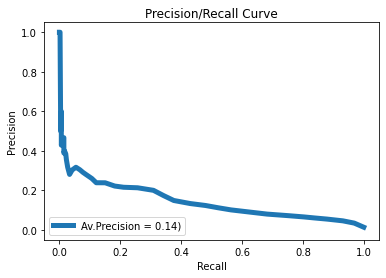

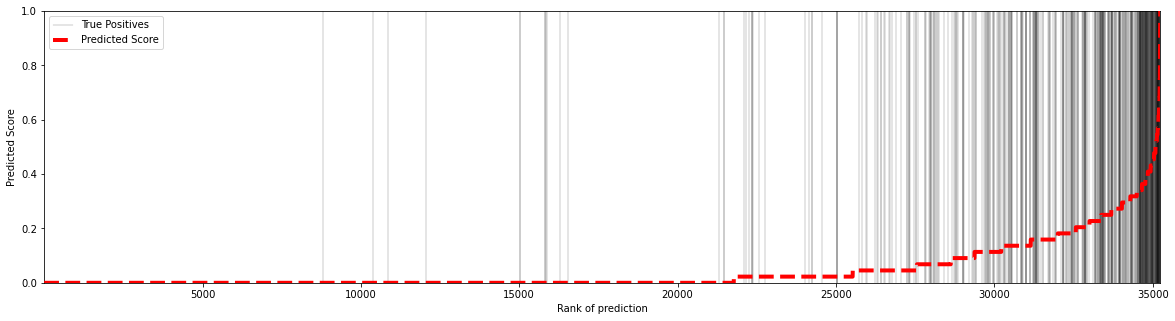

In [12]:
draw_roc_curve(labels_1, data_train['fatal_harm'],"dictionary_fatal_viol_roc_curve")

draw_precision_curve(labels_1, data_train['fatal_harm'],"dictionary_fatal_viol_precision_curve")

draw_roc_curve(labels_2, data_train['tourist_harm_2'],"dictionary_tourist_harm_precision_curve")

draw_precision_curve(labels_2, data_train['tourist_harm_2'],"dictionary_tourist_harm_precision_curve")

#Model critique



sep_data=data_train[["label_2",'tourist_harm_2']]
name=spitout + "separation_plot_dictionary_tourism.pdf"
separation_plot(sep_data, name)

# Model Training
This is the bulk of the code. We train three classifiers per label.

For each label and classifier we go through a grid-search with cross-validation then calculating performance using crossvalfit and plotting the ROC and precision curves. Note that precision falls from label_0, label_1 to label_2 as label_2 is much more unbalanced. After training a random forest, naive bayes and XGB classifier for each label we build a simple ensemble by averaging across all three. This tends to be good for performance and makes our method more robust. 

For label_2 we also retrain after some hand relabeling.


## Grid Search Explanation

The structure of each grid search is always the same but with some details differing on the hyperparameters depending on the classifier used. Key here is that we 

### Pipeline Creation:
Pipeline: This is a scikit-learn Pipeline object, which is a sequence of data processing steps. Each step is represented as a tuple containing the name of the step and the function to be executed.
CountVectorizer: The first step in the pipeline ("vect"), uses CountVectorizer to convert the text data into a matrix of token counts. This is a common way of representing text data for machine learning models.
TfidfTransformer: The second step ("tfidf") applies a TfidfTransformer to the output of CountVectorizer. This transformer calculates the Term Frequency-Inverse Document Frequency (TF-IDF) for each word in the corpus, which reflects how important a word is to a document in a collection of documents.
MultinomialNB: The final step ("clf") is a classifier, MultinomialNB, which stands for Multinomial Naive Bayes. This is a probabilistic learning method commonly used for text classification.

### Parameter Setting:
A dictionary named parameters is defined, which includes the parameters to be tuned for the CountVectorizer and TfidfTransformer steps in the pipeline.
Parameters such as max_df, min_df, and ngram_range are set for CountVectorizer. These control the maximum and minimum document frequency of terms and the range of n-gram sizes to consider.
For TfidfTransformer, parameters like use_idf (whether to use inverse document frequency) and norm (the norm to use for normalization) are set.
Grid Search for Hyperparameter Tuning:

GridSearchCV: This function is used to perform hyperparameter tuning. It takes the pipeline and the parameter dictionary as inputs, along with additional settings like n_jobs (number of jobs to run in parallel), verbose (verbosity level), scoring (a performance metric), and cv (cross-validation splitting strategy).
The grid search will train the pipeline across all combinations of parameters in the parameters dictionary and evaluate the performance using cross-validation.


### Executing the Grid Search:
The grid search is executed on a dataset (Fourtit_text) with corresponding labels (labels_0). The fit method starts the training and evaluation process.
The execution time is calculated and printed.
After completion, the best score and the best parameters found for the model are printed.




## Label 0: Any violence

In [13]:
import random
random.seed(42)

In [14]:
#RF
pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", MultinomialNB()),
    ]
)


parameters = {
    "vect__max_df": ([0.4]),
    "vect__min_df": ([0.007]),
    "vect__ngram_range": ([(1,3)]),  # unigrams or bigrams
    "tfidf__use_idf": ([False]),
    'tfidf__norm': (['l2']),
}

# classifier
grid_search = GridSearchCV(pipeline, parameters, n_jobs=4, verbose=3, scoring='roc_auc', cv=3)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(Fourtit_text, labels_0)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set for label 0:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'tfidf__norm': ['l2'],
 'tfidf__use_idf': [False],
 'vect__max_df': [0.4],
 'vect__min_df': [0.007],
 'vect__ngram_range': [(1, 3)]}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
done in 53.094s

Best score: 0.899
Best parameters set for label 0:
	tfidf__norm: 'l2'
	tfidf__use_idf: False
	vect__max_df: 0.4
	vect__min_df: 0.007
	vect__ngram_range: (1, 3)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:   30.4s finished


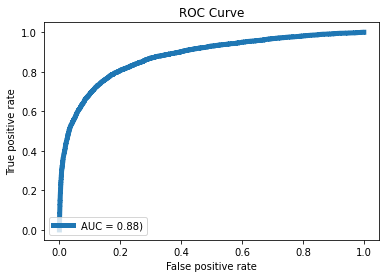

In [15]:
clf_nb0 = grid_search.best_estimator_
y_pred_nb0 = cross_val_predict(clf_nb0, Fourtit_text, labels_0, n_jobs=4, verbose=2, cv=3, method= 'predict_proba')[:,1]
draw_roc_curve(labels_0, y_pred_nb0 ,"ml_nb_any_harm_roc_curve")

### XGB boost label 0

In [17]:
#xgb
pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", xgb.XGBClassifier()),
    ]
)


parameters = {
    "vect__max_df": ([0.4]),
    "vect__min_df": (0.008,0.009),
    "vect__ngram_range": ([(1,3)]),  # unigrams or bigrams
    "tfidf__use_idf": ([True]),
    'tfidf__norm': (['l1']),
    "clf__gamma": ([1]),
    "clf__reg_alpha": ([20]),
    "clf__reg_lambda": ([0.1]),
    "clf__max_depth": ([20]),
    "clf__n_estimators": ([300]),
    "clf__min_child_weight": ([10]),
    "clf__scale_pos_weight": ([28090/7256]),
    "clf__colsample_bytree":([0.7]),
}


# Find the best parameters for both the feature extraction and the
# classifier
grid_search = GridSearchCV(pipeline, parameters, n_jobs=4, verbose=3, scoring='roc_auc', cv=3)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(Fourtit_text, labels_0)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set for label 0:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__colsample_bytree': [0.7],
 'clf__gamma': [1],
 'clf__max_depth': [20],
 'clf__min_child_weight': [10],
 'clf__n_estimators': [300],
 'clf__reg_alpha': [20],
 'clf__reg_lambda': [0.1],
 'clf__scale_pos_weight': [3.871278941565601],
 'tfidf__norm': ['l1'],
 'tfidf__use_idf': [True],
 'vect__max_df': [0.4],
 'vect__min_df': (0.008, 0.009),
 'vect__ngram_range': [(1, 3)]}
Fitting 3 folds for each of 2 candidates, totalling 6 fits


C:\Users\HMueller\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:32:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
done in 635.512s

Best score: 0.901
Best parameters set for label 0:
	clf__colsample_bytree: 0.7
	clf__gamma: 1
	clf__max_depth: 20
	clf__min_child_weight: 10
	clf__n_estimators: 300
	clf__reg_alpha: 20
	clf__reg_lambda: 0.1
	clf__scale_pos_weight: 3.871278941565601
	tfidf__norm: 'l1'
	tfidf__use_idf: True
	vect__max_df: 0.4
	vect__min_df: 0.009
	vect__ngram_range: (1, 3)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  4.1min finished


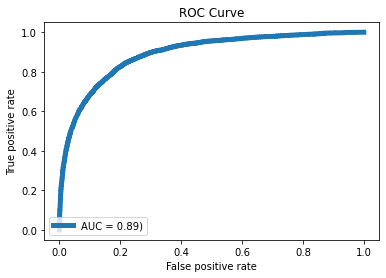

In [18]:
clf_xgb0 = grid_search.best_estimator_
y_pred_xgb0 = cross_val_predict(clf_xgb0, Fourtit_text, labels_0, n_jobs=4, verbose=2, cv=3, method= 'predict_proba')[:,1]
draw_roc_curve(labels_0, y_pred_xgb0 ,"ml_xgb_any_harm_roc_curve")

In [19]:
pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", RandomForestClassifier()),
    ]
)

parameters = {
    "vect__max_df": (0.4,0.5),
    "vect__min_df": (0.005,0.006),
    "vect__ngram_range": ([(1,1)]),  # unigrams or bigrams
    "tfidf__use_idf": ([True]),
    'tfidf__norm': (['l1']),
    "clf__max_depth": ([20]),
    "clf__n_estimators": ([300]),
    "clf__min_samples_leaf": ([10]),
    "clf__class_weight": (["balanced"]),
}

# Find the best parameters for both the feature extraction and the
# classifier
grid_search = GridSearchCV(pipeline, parameters, n_jobs=4, verbose=3, scoring='roc_auc', cv=3)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(Fourtit_text, labels_0)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set for label 0:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__class_weight': ['balanced'],
 'clf__max_depth': [20],
 'clf__min_samples_leaf': [10],
 'clf__n_estimators': [300],
 'tfidf__norm': ['l1'],
 'tfidf__use_idf': [True],
 'vect__max_df': (0.4, 0.5),
 'vect__min_df': (0.005, 0.006),
 'vect__ngram_range': [(1, 1)]}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
done in 254.138s

Best score: 0.900
Best parameters set for label 0:
	clf__class_weight: 'balanced'
	clf__max_depth: 20
	clf__min_samples_leaf: 10
	clf__n_estimators: 300
	tfidf__norm: 'l1'
	tfidf__use_idf: True
	vect__max_df: 0.4
	vect__min_df: 0.005
	vect__ngram_range: (1, 1)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:   49.9s finished


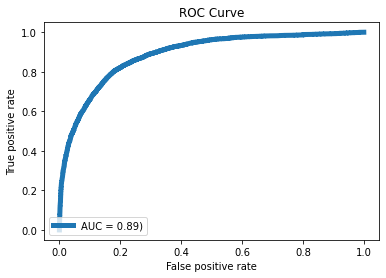

In [20]:
clf_rf0 = grid_search.best_estimator_
y_pred_rf0 = cross_val_predict(clf_rf0, Fourtit_text, labels_0, n_jobs=4, verbose=2, cv=3, method= 'predict_proba')[:,1]
draw_roc_curve(labels_0, y_pred_rf0 ,"ml_rf_any_harm_roc_curve")

### Putting everything together for label 0
This builds the ensemble by simple averaging.

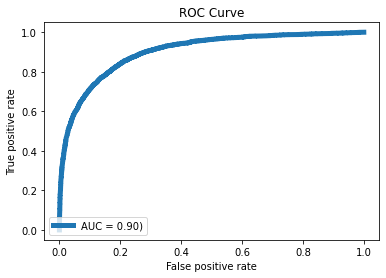

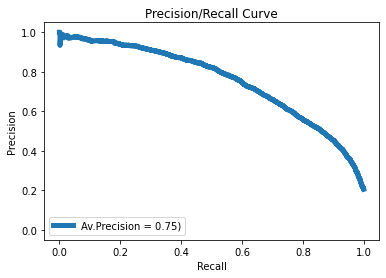

In [21]:
y_pred_ens0=(y_pred_nb0 + y_pred_xgb0 + y_pred_rf0 )/3

draw_roc_curve(labels_0, y_pred_ens0 ,"ml_ens_any_harm_roc_curve")

draw_precision_curve(labels_0, y_pred_ens0 ,"ml_ens_any_harm_precision_curve")

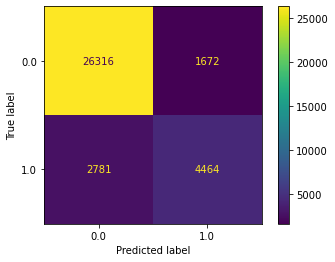

In [22]:
#dummyfy
y_ens_dum0=(y_pred_ens0>0.5)*1

cm = confusion_matrix(labels_0, y_ens_dum0, labels=clf_rf0.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_rf0.classes_)
disp.plot()
plt.show()

# Label 1: Fatal violence

In [23]:

pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", MultinomialNB()),
    ]
)


parameters = {
    "vect__max_df": ([0.4]),
    "vect__min_df": ([0.007]),
    "vect__ngram_range": ([(1,3)]),  # unigrams or bigrams
    "tfidf__use_idf": ([False]),
    'tfidf__norm': (['l2']),
}

# classifier
grid_search = GridSearchCV(pipeline, parameters, n_jobs=4, verbose=3, scoring='roc_auc', cv=3)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(Fourtit_text, labels_1)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set for label 1:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'tfidf__norm': ['l2'],
 'tfidf__use_idf': [False],
 'vect__max_df': [0.4],
 'vect__min_df': [0.007],
 'vect__ngram_range': [(1, 3)]}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
done in 54.923s

Best score: 0.929
Best parameters set for label 1:
	tfidf__norm: 'l2'
	tfidf__use_idf: False
	vect__max_df: 0.4
	vect__min_df: 0.007
	vect__ngram_range: (1, 3)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:   29.4s finished


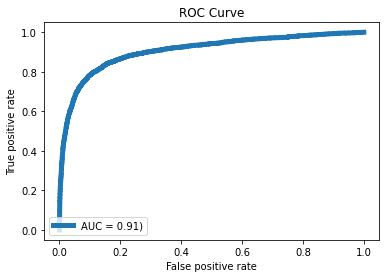

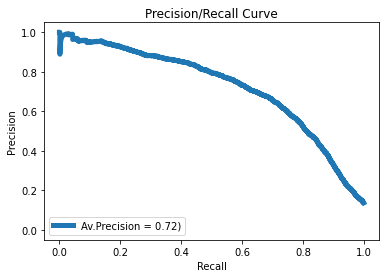

In [24]:
clf_nb1 = grid_search.best_estimator_
y_pred_nb1 = cross_val_predict(clf_nb1, Fourtit_text, labels_1, n_jobs=4, verbose=2, cv=3, method= 'predict_proba')[:,1]
draw_roc_curve(labels_1, y_pred_nb1 ,"ml_nb_fatal_harm_roc_curve")
draw_precision_curve(labels_1, y_pred_nb1,"ml_nb_fatal_harm_precision_curve")


In [25]:
#xgb
pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", xgb.XGBClassifier()),
    ]
)


parameters = {
    "vect__max_df": (0.3, 0.4),
    "vect__min_df": ([0.007]),
    "vect__ngram_range": ([(1,3)]),  # unigrams or bigrams
    "tfidf__use_idf": ([True]),
    'tfidf__norm': (['l1']),
    "clf__gamma": ([1]),
    "clf__reg_alpha": ([20]),
    "clf__reg_lambda": ([0.1]),
    "clf__max_depth": ([20]),
    "clf__n_estimators": ([300]),
    "clf__min_child_weight": ([10]),
    "clf__scale_pos_weight": ([30523/4823]),
    "clf__colsample_bytree":([0.5]),
}


# Find the best parameters for both the feature extraction and the
# classifier
grid_search = GridSearchCV(pipeline, parameters, n_jobs=4, verbose=3, scoring='roc_auc', cv=3)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(Fourtit_text, labels_1)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set for label 1:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__colsample_bytree': [0.5],
 'clf__gamma': [1],
 'clf__max_depth': [20],
 'clf__min_child_weight': [10],
 'clf__n_estimators': [300],
 'clf__reg_alpha': [20],
 'clf__reg_lambda': [0.1],
 'clf__scale_pos_weight': [6.328633630520423],
 'tfidf__norm': ['l1'],
 'tfidf__use_idf': [True],
 'vect__max_df': (0.3, 0.4),
 'vect__min_df': [0.007],
 'vect__ngram_range': [(1, 3)]}
Fitting 3 folds for each of 2 candidates, totalling 6 fits


C:\Users\HMueller\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:51:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
done in 462.800s

Best score: 0.939
Best parameters set for label 1:
	clf__colsample_bytree: 0.5
	clf__gamma: 1
	clf__max_depth: 20
	clf__min_child_weight: 10
	clf__n_estimators: 300
	clf__reg_alpha: 20
	clf__reg_lambda: 0.1
	clf__scale_pos_weight: 6.328633630520423
	tfidf__norm: 'l1'
	tfidf__use_idf: True
	vect__max_df: 0.3
	vect__min_df: 0.007
	vect__ngram_range: (1, 3)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  2.6min finished


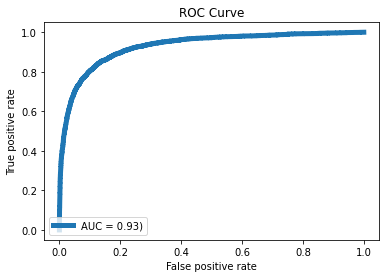

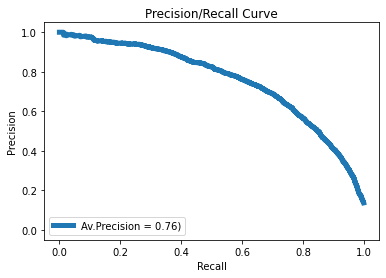

In [26]:
clf_xgb1 = grid_search.best_estimator_
y_pred_xgb1 = cross_val_predict(clf_xgb1, Fourtit_text, labels_1, n_jobs=4, verbose=2, cv=3, method= 'predict_proba')[:,1]
draw_roc_curve(labels_1, y_pred_xgb1 ,"ml_xgb_fatal_harm_roc_curve")
draw_precision_curve(labels_1, y_pred_xgb1,"ml_xgb_fatal_harm_precision_curve")

In [27]:
# Parameters to use for grid search. Uncommenting more parameters will give
# better exploring power but will increase processing time in a combinatorial
# way
pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", RandomForestClassifier()),
    ]
)

parameters = {
    "vect__max_df": (0.3,0.4),
    "vect__min_df": ([0.008]),
    "vect__ngram_range": ([(1,1)]),  # unigrams or bigrams
    "tfidf__use_idf": ([True]),
    'tfidf__norm': (['l1']),
    "clf__max_depth": ([20]),
    "clf__n_estimators": ([300]),
    "clf__min_samples_leaf": ([10]),
    "clf__class_weight": (["balanced"]),
}

# Find the best parameters for both the feature extraction and the
# classifier
grid_search = GridSearchCV(pipeline, parameters, n_jobs=4, verbose=3, scoring='roc_auc', cv=3)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(Fourtit_text, labels_1)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set for label 1:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__class_weight': ['balanced'],
 'clf__max_depth': [20],
 'clf__min_samples_leaf': [10],
 'clf__n_estimators': [300],
 'tfidf__norm': ['l1'],
 'tfidf__use_idf': [True],
 'vect__max_df': (0.3, 0.4),
 'vect__min_df': [0.008],
 'vect__ngram_range': [(1, 1)]}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
done in 181.695s

Best score: 0.938
Best parameters set for label 1:
	clf__class_weight: 'balanced'
	clf__max_depth: 20
	clf__min_samples_leaf: 10
	clf__n_estimators: 300
	tfidf__norm: 'l1'
	tfidf__use_idf: True
	vect__max_df: 0.3
	vect__min_df: 0.008
	vect__ngram_range: (1, 1)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  1.1min finished


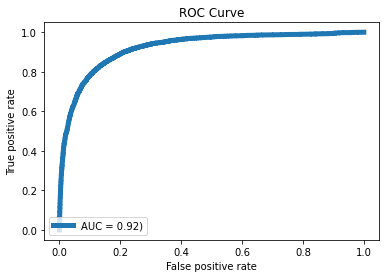

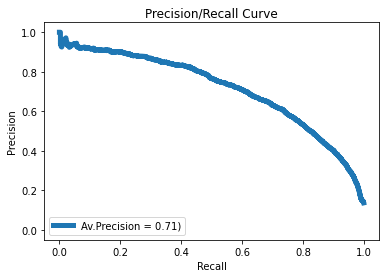

In [28]:
clf_rf1 = grid_search.best_estimator_
y_pred_rf1 = cross_val_predict(clf_rf1, Fourtit_text, labels_1, n_jobs=4, verbose=2, cv=3, method= 'predict_proba')[:,1]
draw_roc_curve(labels_1, y_pred_rf1 ,"ml_rf_fatal_harm_roc_curve")
draw_precision_curve(labels_1, y_pred_rf1,"ml_rf_fatal_harm_precision_curve")

### Putting everything together for label 1

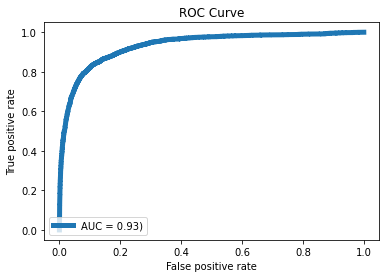

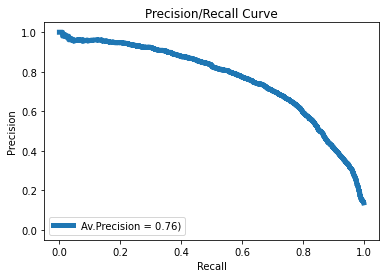

In [29]:
y_pred_ens1=(y_pred_nb1 + y_pred_xgb1 + y_pred_rf1 )/3

draw_roc_curve(labels_1, y_pred_ens1 ,"ml_ens_fatal_harm_roc_curve")

draw_precision_curve(labels_1, y_pred_ens1 ,"ml_ens_fatal_harm_precision_curve")

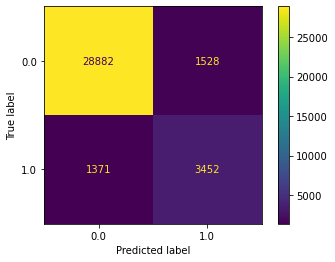

In [30]:
#dummyfy
y_ens_dum1=(y_pred_ens1>0.5)*1

cm = confusion_matrix(labels_1, y_ens_dum1, labels=clf_rf1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_rf1.classes_)
disp.plot()
plt.show()

## Label 2: Tourist harm (note human recoding)

In [31]:

pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", MultinomialNB()),
    ]
)


parameters = {
    "vect__max_df": ([0.3]),
    "vect__min_df": ([0.01]),
    "vect__ngram_range": ([(1,3)]),  # unigrams or bigrams
    "tfidf__use_idf": ([True]),
    'tfidf__norm': (['l2']),
}

# classifier
grid_search = GridSearchCV(pipeline, parameters, n_jobs=4, verbose=3, scoring='roc_auc', cv=3)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(Fourtit_text, labels_2)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set for label 2:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'tfidf__norm': ['l2'],
 'tfidf__use_idf': [True],
 'vect__max_df': [0.3],
 'vect__min_df': [0.01],
 'vect__ngram_range': [(1, 3)]}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
done in 86.975s

Best score: 0.943
Best parameters set for label 2:
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__max_df: 0.3
	vect__min_df: 0.01
	vect__ngram_range: (1, 3)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  1.3min finished


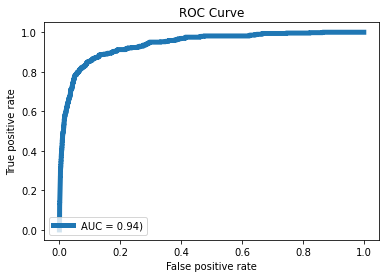

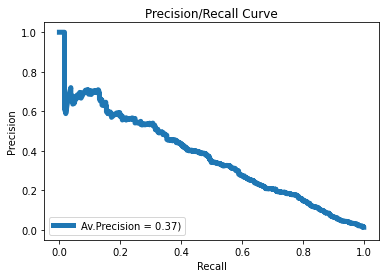

In [32]:
clf_nb2 = grid_search.best_estimator_
y_pred_nb2 = cross_val_predict(clf_nb2, Fourtit_text, labels_2, n_jobs=4, verbose=2, cv=3, method= 'predict_proba')[:,1]
draw_roc_curve(labels_2, y_pred_nb2 ,"ml_nb_tourist_harm_roc_curve")
draw_precision_curve(labels_2, y_pred_nb2,"ml_nb_tourist_harm_precision_curve")

In [33]:
#xgb
pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", xgb.XGBClassifier()),
    ]
)


parameters = {
    "vect__max_df": ([0.25]),
    "vect__min_df": (0.004, 0.005),
    "vect__ngram_range": ([(1,3)]),  # unigrams or bigrams
    "tfidf__use_idf": ([True]),
    'tfidf__norm': (['l1']),
    "clf__gamma": ([1]),
    "clf__reg_alpha": ([15]),
    "clf__reg_lambda": ([0.1]),
    "clf__max_depth": ([25]),
    "clf__n_estimators": ([300]),
    "clf__min_child_weight": ([5]),
    "clf__scale_pos_weight": ([10]),
    "clf__colsample_bytree":([0.2]),
}

# classifier
grid_search = GridSearchCV(pipeline, parameters, n_jobs=4, verbose=3, scoring='roc_auc', cv=3)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(Fourtit_text, labels_2)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set for label 2:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__colsample_bytree': [0.2],
 'clf__gamma': [1],
 'clf__max_depth': [25],
 'clf__min_child_weight': [5],
 'clf__n_estimators': [300],
 'clf__reg_alpha': [15],
 'clf__reg_lambda': [0.1],
 'clf__scale_pos_weight': [10],
 'tfidf__norm': ['l1'],
 'tfidf__use_idf': [True],
 'vect__max_df': [0.25],
 'vect__min_df': (0.004, 0.005),
 'vect__ngram_range': [(1, 3)]}
Fitting 3 folds for each of 2 candidates, totalling 6 fits


C:\Users\HMueller\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:09:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
done in 490.549s

Best score: 0.968
Best parameters set for label 2:
	clf__colsample_bytree: 0.2
	clf__gamma: 1
	clf__max_depth: 25
	clf__min_child_weight: 5
	clf__n_estimators: 300
	clf__reg_alpha: 15
	clf__reg_lambda: 0.1
	clf__scale_pos_weight: 10
	tfidf__norm: 'l1'
	tfidf__use_idf: True
	vect__max_df: 0.25
	vect__min_df: 0.004
	vect__ngram_range: (1, 3)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  1.1min finished


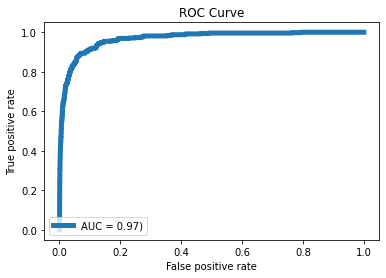

In [34]:
clf_xgb2 = grid_search.best_estimator_
y_pred_xgb2 = cross_val_predict(clf_xgb2, Fourtit_text, labels_2, n_jobs=4, verbose=2, cv=3, method= 'predict_proba')[:,1]
draw_roc_curve(labels_2, y_pred_xgb2 ,"ml_nb_tourist_harm_roc_curve")

In [35]:
# Parameters to use for grid search. Uncommenting more parameters will give
# better exploring power but will increase processing time in a combinatorial
# way
pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", RandomForestClassifier()),
    ]
)

parameters = {
    "vect__max_df": ([0.4]),
    "vect__min_df": ([0.004]),
    "vect__ngram_range": ([(1,1)]),  # unigrams or bigrams
    "tfidf__use_idf": ([True]),
    'tfidf__norm': (['l1']),
    "clf__max_depth": ([20]),
    "clf__n_estimators": ([300]),
    "clf__min_samples_leaf": ([10]),
    "clf__class_weight": (["balanced"]),
}

# Find the best parameters for both the feature extraction and the
# classifier
grid_search = GridSearchCV(pipeline, parameters, n_jobs=4, verbose=3, scoring='roc_auc', cv=3)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(Fourtit_text, labels_2)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set for label 2:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__class_weight': ['balanced'],
 'clf__max_depth': [20],
 'clf__min_samples_leaf': [10],
 'clf__n_estimators': [300],
 'tfidf__norm': ['l1'],
 'tfidf__use_idf': [True],
 'vect__max_df': [0.4],
 'vect__min_df': [0.004],
 'vect__ngram_range': [(1, 1)]}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
done in 78.337s

Best score: 0.968
Best parameters set for label 2:
	clf__class_weight: 'balanced'
	clf__max_depth: 20
	clf__min_samples_leaf: 10
	clf__n_estimators: 300
	tfidf__norm: 'l1'
	tfidf__use_idf: True
	vect__max_df: 0.4
	vect__min_df: 0.004
	vect__ngram_range: (1, 1)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:   34.2s finished


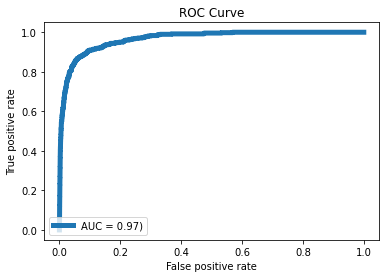

In [36]:
clf_rf2 = grid_search.best_estimator_
y_pred_rf2 = cross_val_predict(clf_rf2, Fourtit_text, labels_2, n_jobs=4, verbose=2, cv=3, method= 'predict_proba')[:,1]
draw_roc_curve(labels_2, y_pred_rf2 ,"ml_rf_tourist_harm_roc_curve")

### Putting everything together for label 2

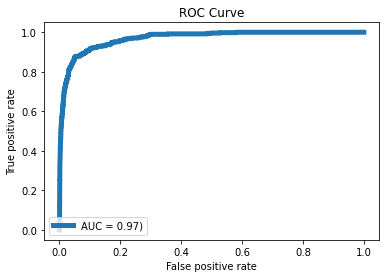

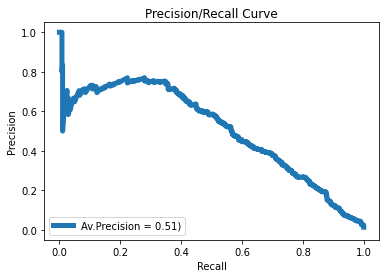

In [37]:
y_pred_ens2=(y_pred_nb2 + y_pred_xgb2 + y_pred_rf2 )/3

draw_roc_curve(labels_2, y_pred_ens2 ,"ml_ens_tourist_harm_roc_curve")

draw_precision_curve(labels_2, y_pred_ens2 ,"ml_ens_tourist_harm_precision_curve")

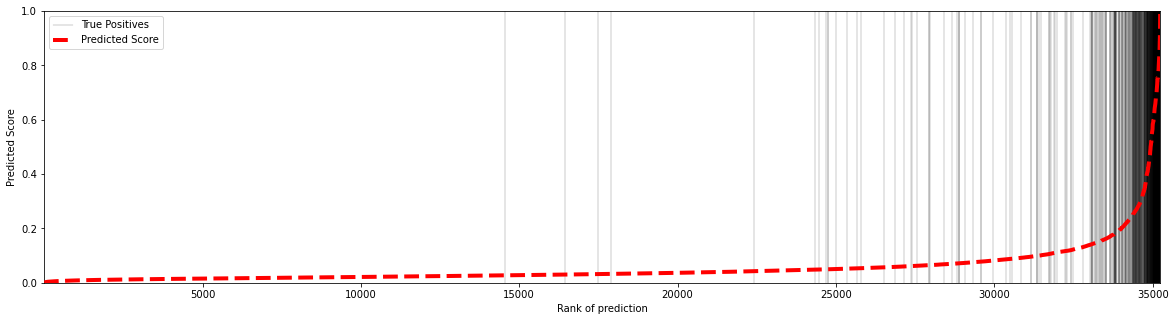

In [38]:
data_train['y_pred_ens2']=y_pred_ens2
sep_data=data_train[["label_2",'y_pred_ens2']]
name=spitout + "separation_plot_ml_tourism.pdf"
separation_plot(sep_data, name)

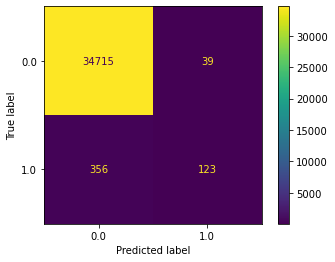

In [39]:
#dummyfy
y_ens_dum2=(y_pred_ens2>0.5)*1

cm = confusion_matrix(labels_2, y_ens_dum2, labels=clf_rf2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_rf2.classes_)
disp.plot()
plt.show()

In [40]:
i=0
for text in data_train.title_text[(data_train["label_2"]==0)&(data_train['y_pred_ens2']>0.5)]:
    print("Full text for article:",i)
    print(text)
    print("  ")
    i+=1

Full text for article: 0
turkey france hit attack recent month istanbul turkey tourism industry also taken hit following bomb attack capital ankara october suicide bomber tuesday killed people left wounded istanbul tourist district sultanahmet near major tourist attraction including blue mosque hagia sophia killed german tourist make largest share holidaymaker turkey threatening industry car bomb attack thursday kurdish militant police station housing officer killed wounded score people southeastern turkey turkey already lost russian tourist due weakening rouble spat russia another big supplier visitor chebib said estimated loss turkey tourism income reach billion john podaras partner consultancy hotel development resource said attack bound longer term implication turkish tourism industry turkey tourism profit fell per cent billion third quarter chebib said turkey attracted million visitor generated billion tourism revenue anand said cox king take precaution guide tourist alternate des

In [41]:
i=0
for text in data_train.title_text[(data_train["label_2"]==0)&(data_train['y_pred_ens2']>0.5)]:
    print("Full text for article:",i)
    print(text)
    print("  ")
    i+=1

Full text for article: 0
turkey france hit attack recent month istanbul turkey tourism industry also taken hit following bomb attack capital ankara october suicide bomber tuesday killed people left wounded istanbul tourist district sultanahmet near major tourist attraction including blue mosque hagia sophia killed german tourist make largest share holidaymaker turkey threatening industry car bomb attack thursday kurdish militant police station housing officer killed wounded score people southeastern turkey turkey already lost russian tourist due weakening rouble spat russia another big supplier visitor chebib said estimated loss turkey tourism income reach billion john podaras partner consultancy hotel development resource said attack bound longer term implication turkish tourism industry turkey tourism profit fell per cent billion third quarter chebib said turkey attracted million visitor generated billion tourism revenue anand said cox king take precaution guide tourist alternate des

In [42]:
i=0
for text in data_train.titles_lemm[(data_train["label_2"]==0)&(data_train['y_pred_ens2']>0.5)]:
    print("Lemmatized title for article:",i)
    print(text)
    print("  ")
    i+=1

Lemmatized title for article: 0
attack dent tourism popular holiday destination 
  
Lemmatized title for article: 1
extra police armed guard protect tourist 
  
Lemmatized title for article: 2
extremism thrives fertile soil poverty revolt beach bloodbath radical mosque slated closure 
  
Lemmatized title for article: 3
slaughter tunisia claim life gentle sydney man terror attack family tragedy 
  
Lemmatized title for article: 4
tunisian police kill two terrorist stop planned simultaneous attack 
  
Lemmatized title for article: 5
OIC condemns bardo museum terror attack 
  
Lemmatized title for article: 6
bahrain condemns terrorist attack tunisia 
  
Lemmatized title for article: 7
sightseeing 
  
Lemmatized title for article: 8
common destiny tragedy 
  
Lemmatized title for article: 9
president guard targeted tunisian blast kill state emergency declared young democracy capital massive explosion bus 
  
Lemmatized title for article: 10
ISIS follower dangerous leader carnage tunisia ku

In [43]:
#as a result of this we are relabeling the following titles towards label_2=1

stringlist=["slaughter tunisia claim life gentle sydney man",
            "OIC condemns bardo museum terror attack",
            "bahrain condemns terrorist attack tunisia",
            "dozen dead attack spread fear across world day ISIS spokesman issued warning strike rock tunisia kuwait france",
            "islamic state say attacked museum group claim behind massacre tunisia killed authority say two gunman link terrorist",
            "gunman shot anything moved least massacred militant storm tunisian museum north african country deadliest civilian attack year",
            "backgrounder deadly attack egypt since",
            "belarus strongly condemns terrorist attack turkey",
            "backgrounder recent terror attack turkey glance",
            "1st LD writethru UN chief slam deadly terrorist attack istanbul",
            "BYLINE CEMBRERO RIZZI",
            "pilgrim killed bomb attack sinai bus",
            "killed caf eacute terrorist target tourist marrakesh",
            "tunisia stunned home grown terror",
            "blast istanbul tourist square kill foreigner among injured",
            "bloody attack tunisia",
            "tunisia taking stock dead survivor",
            "fatal museum attack blow tunisia democratic shift",
            "lucky escape SA tourist"]
for strings in stringlist:
    data_train.loc[data_train['titles_lemm'].str.contains(strings),("label_2")]=1
    full_data.loc[full_data['titles_lemm'].str.contains(strings),("label_2")]=1

## Redoing label 2 after human relabeling

In [44]:
labels_2 = data_train.label_2.tolist()

In [45]:
pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", MultinomialNB()),
    ]
)


parameters = {
    "vect__max_df": (0.2, 0.3, 0.4),
    "vect__min_df": (0.009, 0.01, 0.015),
    "vect__ngram_range": ((1,1), (1,3)),  # unigrams or bigrams
    "tfidf__use_idf": ([True]),
    'tfidf__norm': (['l2']),
}

# classifier
grid_search = GridSearchCV(pipeline, parameters, n_jobs=4, verbose=3, scoring='roc_auc', cv=5)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(Fourtit_text, labels_2)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set for label 2:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'tfidf__norm': ['l2'],
 'tfidf__use_idf': [True],
 'vect__max_df': (0.2, 0.3, 0.4),
 'vect__min_df': (0.009, 0.01, 0.015),
 'vect__ngram_range': ((1, 1), (1, 3))}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
done in 615.137s

Best score: 0.952
Best parameters set for label 2:
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__max_df: 0.4
	vect__min_df: 0.015
	vect__ngram_range: (1, 3)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.1min finished


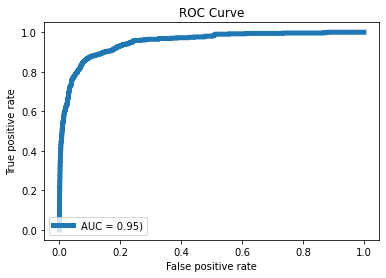

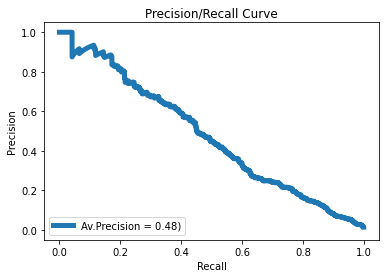

In [46]:
clf_nb2 = grid_search.best_estimator_
y_pred_nb2 = cross_val_predict(clf_nb2, Fourtit_text, labels_2, n_jobs=4, verbose=2, cv=5, method= 'predict_proba')[:,1]
draw_roc_curve(labels_2, y_pred_nb2 ,"ml_nb_tourist_harm_roc_curve")
draw_precision_curve(labels_2, y_pred_nb2,"ml_nb_tourist_harm_precision_curve")

In [47]:
#xgb
pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", xgb.XGBClassifier()),
    ]
)


parameters = {
    "vect__max_df": (0.1, 0.25, 0.5),
    "vect__min_df": (0.004, 0.005, 0.006),
    "vect__ngram_range": ([(1,1)]),  # unigrams or bigrams
    "tfidf__use_idf": ([True]),
    'tfidf__norm': (['l1']),
    "clf__gamma": ([1]),
    "clf__reg_alpha": (5, 15),
    "clf__reg_lambda": ([0.1]),
    "clf__max_depth": ([25]),
    "clf__n_estimators": ([300]),
    "clf__min_child_weight": ([5]),
    "clf__scale_pos_weight": ([10]),
    "clf__colsample_bytree":(0.15,0.25,0.35),
}

# classifier
grid_search = GridSearchCV(pipeline, parameters, n_jobs=4, verbose=3, scoring='roc_auc', cv=5)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(Fourtit_text, labels_2)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set for label 2:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__colsample_bytree': (0.15, 0.25, 0.35),
 'clf__gamma': [1],
 'clf__max_depth': [25],
 'clf__min_child_weight': [5],
 'clf__n_estimators': [300],
 'clf__reg_alpha': (5, 15),
 'clf__reg_lambda': [0.1],
 'clf__scale_pos_weight': [10],
 'tfidf__norm': ['l1'],
 'tfidf__use_idf': [True],
 'vect__max_df': (0.1, 0.25, 0.5),
 'vect__min_df': (0.004, 0.005, 0.006),
 'vect__ngram_range': [(1, 1)]}
Fitting 5 folds for each of 54 candidates, totalling 270 fits


C:\Users\HMueller\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:19:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
done in 6900.140s

Best score: 0.977
Best parameters set for label 2:
	clf__colsample_bytree: 0.25
	clf__gamma: 1
	clf__max_depth: 25
	clf__min_child_weight: 5
	clf__n_estimators: 300
	clf__reg_alpha: 15
	clf__reg_lambda: 0.1
	clf__scale_pos_weight: 10
	tfidf__norm: 'l1'
	tfidf__use_idf: True
	vect__max_df: 0.25
	vect__min_df: 0.005
	vect__ngram_range: (1, 1)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.5min finished


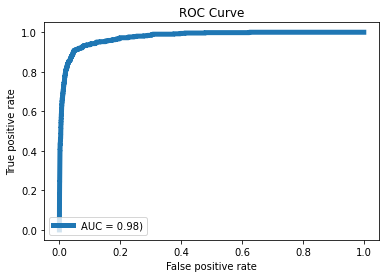

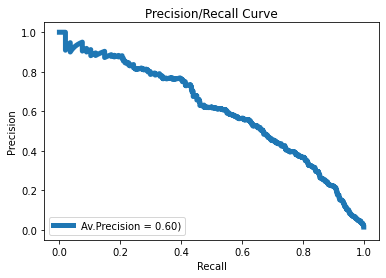

In [48]:
clf_xgb2 = grid_search.best_estimator_
y_pred_xgb2 = cross_val_predict(clf_xgb2, Fourtit_text, labels_2, n_jobs=4, verbose=2, cv=5, method= 'predict_proba')[:,1]
draw_roc_curve(labels_2, y_pred_xgb2 ,"ml_xgb_tourist_harm_roc_curve")
draw_precision_curve(labels_2, y_pred_xgb2,"ml_xgb_tourist_harm_precision_curve")

In [49]:
# Parameters to use for grid search. Uncommenting more parameters will give
# better exploring power but will increase processing time in a combinatorial
# way
pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", RandomForestClassifier()),
    ]
)

parameters = {
    "vect__max_df": (0.5,0.6,0.7),
    "vect__min_df": (0.007,0.008,0.009,0.01),
    "vect__ngram_range": ([(1,1)]),  # unigrams or bigrams
    "tfidf__use_idf": ([True]),
    'tfidf__norm': (['l1']),
    "clf__max_depth": ([20]),
    "clf__n_estimators": ([300]),
    "clf__min_samples_leaf": ([10]),
    "clf__class_weight": (["balanced"]),
}


# Find the best parameters for both the feature extraction and the
# classifier
grid_search = GridSearchCV(pipeline, parameters, n_jobs=4, verbose=3, scoring='roc_auc', cv=5)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(Fourtit_text, labels_2)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set for label 2:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__class_weight': ['balanced'],
 'clf__max_depth': [20],
 'clf__min_samples_leaf': [10],
 'clf__n_estimators': [300],
 'tfidf__norm': ['l1'],
 'tfidf__use_idf': [True],
 'vect__max_df': (0.5, 0.6, 0.7),
 'vect__min_df': (0.007, 0.008, 0.009, 0.01),
 'vect__ngram_range': [(1, 1)]}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
done in 1470.940s

Best score: 0.973
Best parameters set for label 2:
	clf__class_weight: 'balanced'
	clf__max_depth: 20
	clf__min_samples_leaf: 10
	clf__n_estimators: 300
	tfidf__norm: 'l1'
	tfidf__use_idf: True
	vect__max_df: 0.6
	vect__min_df: 0.009
	vect__ngram_range: (1, 1)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  2.3min finished


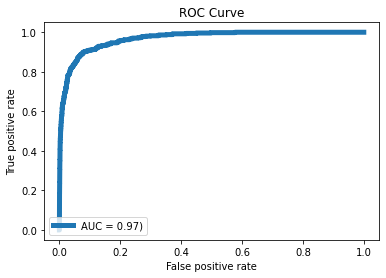

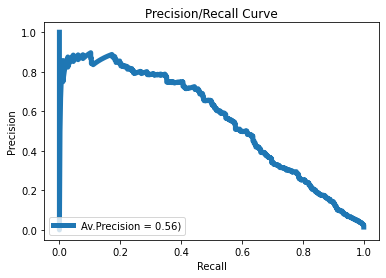

In [50]:

clf_rf2 = grid_search.best_estimator_
y_pred_rf2 = cross_val_predict(clf_rf2, Fourtit_text, labels_2, n_jobs=4, verbose=2, cv=5, method= 'predict_proba')[:,1]
draw_roc_curve(labels_2, y_pred_rf2 ,"ml_rf_tourist_harm_roc_curve")
draw_precision_curve(labels_2, y_pred_rf2,"ml_rf_tourist_harm_precision_curve")


### Putting everything together for label 2 after recoding

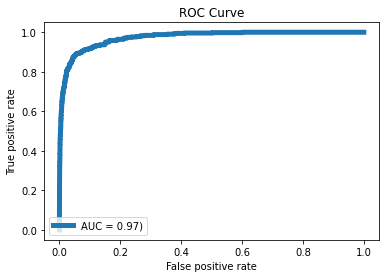

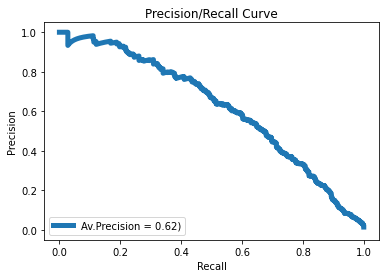

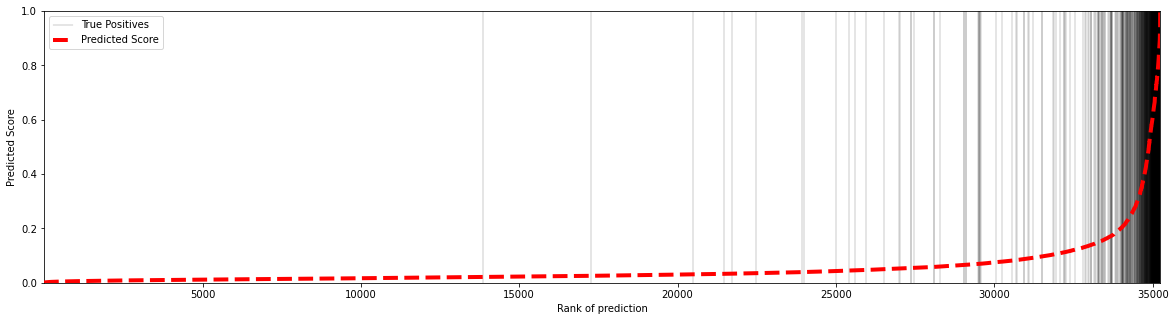

In [51]:

y_pred_ens2=(y_pred_nb2 + y_pred_xgb2 + y_pred_rf2 )/3

draw_roc_curve(labels_2, y_pred_ens2 ,"ml_ens_tourist_harm_roc_curve")

draw_precision_curve(labels_2, y_pred_ens2 ,"ml_ens_tourist_harm_precision_curve")

data_train['y_pred_ens2']=y_pred_ens2
sep_data=data_train[["label_2",'y_pred_ens2']]
name=spitout + "separation_plot_ml_tourism.pdf"
separation_plot(sep_data, name)


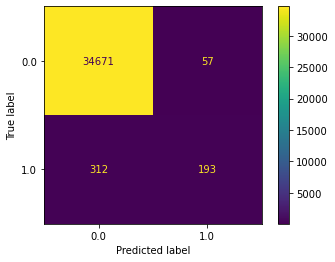

In [52]:
#dummyfy
y_ens_dum2=(y_pred_ens2>0.5)*1

cm = confusion_matrix(labels_2, y_ens_dum2, labels=clf_rf2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_rf2.classes_)
disp.plot()
plt.show()

In [53]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35233 entries, 0 to 35232
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   issuing_iso3c        35233 non-null  object 
 1   dest_iso3c           35233 non-null  object 
 2   year                 35233 non-null  float64
 3   monthnum             35233 non-null  float64
 4   day                  35233 non-null  float64
 5   title_text           35233 non-null  object 
 6   text_with_head_lemm  35233 non-null  object 
 7   titles_lemm          35233 non-null  object 
 8   label_0              35233 non-null  float64
 9   label_1              35233 non-null  float64
 10  label_2              35233 non-null  float64
 11  label_3              35233 non-null  float64
 12  T_H_count            35233 non-null  int64  
 13  alength              35233 non-null  int64  
 14  H_count              35233 non-null  int64  
 15  T_count              35233 non-null 

# Out of sample predictions for entire sample

In [54]:
# Make predictions

Fourtit_text_main=full_data.title_text.tolist()

y_pred_proba_rf0 = clf_rf0.predict_proba(Fourtit_text_main)
full_data['proba_anyVio_RF'] = y_pred_proba_rf0[:,1]
y_pred_proba_rf1 = clf_rf1.predict_proba(Fourtit_text_main)
full_data['proba_Vio_RF'] = y_pred_proba_rf1[:,1]
y_pred_proba_rf2 = clf_rf2.predict_proba(Fourtit_text_main)
full_data['proba_T_RF'] = y_pred_proba_rf2[:,1]

y_pred_proba_xgb0 = clf_xgb0.predict_proba(Fourtit_text_main)
full_data['proba_anyVio_XGB'] = y_pred_proba_xgb0[:,1]
y_pred_proba_xgb1 = clf_xgb1.predict_proba(Fourtit_text_main)
full_data['proba_Vio_XGB'] = y_pred_proba_xgb1[:,1]
y_pred_proba_xgb2 = clf_xgb2.predict_proba(Fourtit_text_main)
full_data['proba_T_XGB'] = y_pred_proba_xgb2[:,1]

y_pred_proba_nb0 = clf_nb0.predict_proba(Fourtit_text_main)
full_data['proba_anyVio_NB'] = y_pred_proba_nb0[:,1]
y_pred_proba_nb1 = clf_nb1.predict_proba(Fourtit_text_main)
full_data['proba_Vio_NB'] = y_pred_proba_nb1[:,1]
y_pred_proba_nb2 = clf_nb2.predict_proba(Fourtit_text_main)
full_data['proba_T_NB'] = y_pred_proba_nb2[:,1]

full_data.to_csv('output_2022_11.csv',sep=',',encoding='utf-8')

# Sri-lanka out of sample

This section takes a dataframe from a completely different news corpus on Sri-Lanka and applies the pipeline with pre-processing and applying the three ensemble classifiers.

In [81]:
#third dataset
path_test='C:\\Dropbox\\Violence and Tourism\\Replication\\01 Data\\confidential'
filename_test ="df_corpus_sri_lanka.csv"

sri_lanka_data = pd.read_csv(os.path.join(path_test, filename_test), sep=',', encoding='utf-8')

    

sri_lanka_data.head()

sri_lanka_data.rename(columns = {'article_id':'ARTICLENUMID'}, inplace = True)
sri_lanka_data.rename(columns = {'article':'TXT_EN'}, inplace = True)
sri_lanka_data.rename(columns = {'title':'TITLE_EN'}, inplace = True)
sri_lanka_data['label_0'] = np.nan
sri_lanka_data['label_1'] = np.nan
sri_lanka_data['label_2'] = np.nan
sri_lanka_data['label_3'] = np.nan

sri_lanka_data=sri_lanka_data.dropna(subset=['TXT_EN'])

sri_lanka_data=sri_lanka_data.reset_index()

sri_lanka_data['date'] = pd.to_datetime(sri_lanka_data['date'], format='%Y%m%d')

# Extract 'year,' 'month,' and 'day' columns
sri_lanka_data['year'] = sri_lanka_data['date'].dt.year
sri_lanka_data['monthnum'] = sri_lanka_data['date'].dt.month
sri_lanka_data['day'] = sri_lanka_data['date'].dt.day

sri_lanka_data.info()




lmtzr = WordNetLemmatizer()
new_stopwords = set(stopwords.words('english'))

mod=0 #=1 means stemming, =2 means lemmatizing, =0 just lowercase

#pre-process title
tit_preproc = (
    sri_lanka_data.TITLE_EN
    .astype(str)
    .progress_apply(lambda row: tokenize(row, mod))
)

sri_lanka_data["titles_lemm"]=tit_preproc

#pre-process text
text_preproc = (
    sri_lanka_data.TXT_EN
    .astype(str)
    .progress_apply(lambda row: tokenize(row, mod))
)

sri_lanka_data["text_with_head_lemm"]=text_preproc

print("done with text plus titles")

sri_lanka_data = sri_lanka_data.dropna(subset=['titles_lemm']).reset_index(drop=True)

sri_lanka_data  = sri_lanka_data[['ARTICLENUMID', 'year','monthnum','day','paper','titles_lemm', 'text_with_head_lemm'
                        ,'label_0','label_1','label_2','label_3']]

sri_lanka_data.to_csv('sri_lanka_lemmatized.csv',sep=',',encoding='utf-8')




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15322 entries, 0 to 15321
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   index         15322 non-null  int64         
 1   Unnamed: 0    15322 non-null  int64         
 2   ARTICLENUMID  15322 non-null  int64         
 3   date          15322 non-null  datetime64[ns]
 4   paper         15322 non-null  object        
 5   TITLE_EN      15202 non-null  object        
 6   TXT_EN        15322 non-null  object        
 7   label_0       0 non-null      float64       
 8   label_1       0 non-null      float64       
 9   label_2       0 non-null      float64       
 10  label_3       0 non-null      float64       
 11  year          15322 non-null  int64         
 12  monthnum      15322 non-null  int64         
 13  day           15322 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(6), object(3)
memory usage: 1.6+ MB


100%|███████████████████████████████████████████████████████████████████████████| 15322/15322 [00:16<00:00, 917.84it/s]


done with text plus titles


In [82]:
sri_lanka_data['titles_lemm'] = sri_lanka_data['titles_lemm'].astype(str)
sri_lanka_data['text_with_head_lemm'] = sri_lanka_data['text_with_head_lemm'].astype(str)
#four times title following Cage
sri_lanka_data['title_text']=sri_lanka_data['text_with_head_lemm']+sri_lanka_data['titles_lemm']+sri_lanka_data['titles_lemm']+sri_lanka_data['titles_lemm']+sri_lanka_data['titles_lemm']



Fourtit_text_main=sri_lanka_data.title_text.tolist()

y_pred_proba_rf0 = clf_rf0.predict_proba(Fourtit_text_main)
sri_lanka_data['proba_anyVio_RF'] = y_pred_proba_rf0[:,1]
y_pred_proba_rf1 = clf_rf1.predict_proba(Fourtit_text_main)
sri_lanka_data['proba_Vio_RF'] = y_pred_proba_rf1[:,1]
y_pred_proba_rf2 = clf_rf2.predict_proba(Fourtit_text_main)
sri_lanka_data['proba_T_RF'] = y_pred_proba_rf2[:,1]

y_pred_proba_xgb0 = clf_xgb0.predict_proba(Fourtit_text_main)
sri_lanka_data['proba_anyVio_XGB'] = y_pred_proba_xgb0[:,1]
y_pred_proba_xgb1 = clf_xgb1.predict_proba(Fourtit_text_main)
sri_lanka_data['proba_Vio_XGB'] = y_pred_proba_xgb1[:,1]
y_pred_proba_xgb2 = clf_xgb2.predict_proba(Fourtit_text_main)
sri_lanka_data['proba_T_XGB'] = y_pred_proba_xgb2[:,1]

y_pred_proba_nb0 = clf_nb0.predict_proba(Fourtit_text_main)
sri_lanka_data['proba_anyVio_NB'] = y_pred_proba_nb0[:,1]
y_pred_proba_nb1 = clf_nb1.predict_proba(Fourtit_text_main)
sri_lanka_data['proba_Vio_NB'] = y_pred_proba_nb1[:,1]
y_pred_proba_nb2 = clf_nb2.predict_proba(Fourtit_text_main)
sri_lanka_data['proba_T_NB'] = y_pred_proba_nb2[:,1]


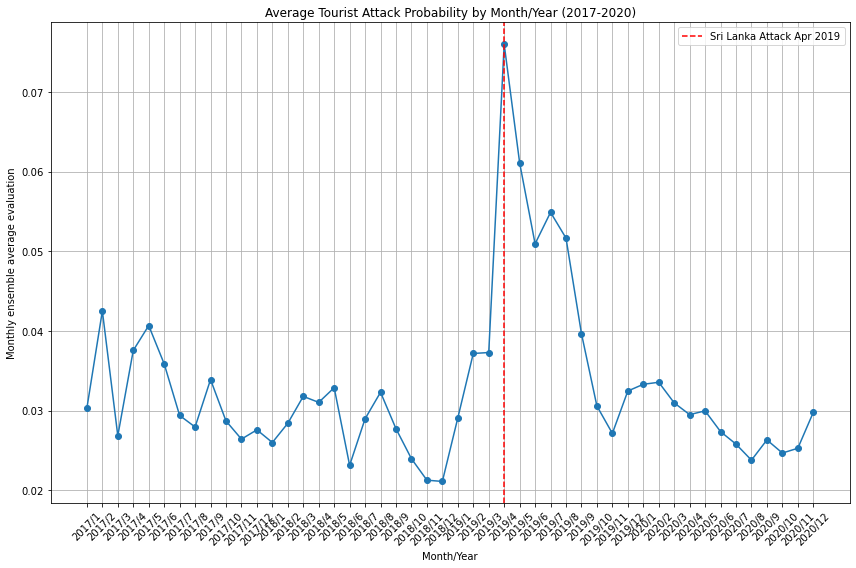

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'sri_lanka_data'
# Calculate the average of the three tourist probability columns
sri_lanka_data['average_proba_T'] = sri_lanka_data[['proba_T_RF', 'proba_T_XGB', 'proba_T_NB']].mean(axis=1)

# Create an indicator column based on the average probability
sri_lanka_data['tourist_attack_indicator'] = (sri_lanka_data['average_proba_T'] > 0.5).astype(int)

# Group the data by 'year' and 'monthnum' and calculate the share of articles with indicator=1
monthly_share = sri_lanka_data.groupby(['year', 'monthnum'])['average_proba_T'].mean()

# Reset the index for plotting
monthly_share = monthly_share.reset_index()

# Filter the dataframe to include only data from 2015 to 2020
filtered_data = monthly_share[(monthly_share['year'] >= 2017) & (monthly_share['year'] < 2021)]

# Create a figure to plot the share of articles with indicator=1
plt.figure(figsize=(12, 8))
plt.plot(filtered_data.index, filtered_data['average_proba_T'], marker='o', linestyle='-')

# Add a red vertical line for April 2019 to indicate the terror attack in Sri Lanka
attack_date = filtered_data[(filtered_data['year'] == 2019) & (filtered_data['monthnum'] == 4)].index[0]
plt.axvline(x=attack_date, color='red', linestyle='--', label='Sri Lanka Attack Apr 2019')

# Set labels, title, and other properties
plt.xlabel('Month/Year')
plt.ylabel('Monthly ensemble average evaluation')
plt.title('Average Tourist Attack Probability by Month/Year (2017-2020)')

# Modify x-ticks: Show every 2nd month
n = 1
labels = filtered_data['year'].astype(str) + '/' + filtered_data['monthnum'].astype(str)
plt.xticks(filtered_data.index[::n], labels[::n], rotation=45, fontsize=10)

plt.grid(True)
plt.legend()  # To display the label for the red line
plt.tight_layout()
name="out_of_sample_sri_lanka.pdf"
plt.savefig(spitout+name+'.pdf')
plt.show()


In [84]:
# Sort the dataframe by 'average_proba_T' in descending order
sorted_data = sri_lanka_data.sort_values(by='average_proba_T', ascending=False)

# Select the top 20 rows
top_20 = sorted_data.head(20)

# Print the first 100 characters of the 'TXT_EN' column for each of the top 20 rows
for index, row in top_20.iterrows():
    print(row['titles_lemm'][:100])
    print('-' * 100)  # Separator for better readability

suspects easter bombings extradited sri lanka 
----------------------------------------------------------------------------------------------------
sri lanka police arrest members banned islamic group 
----------------------------------------------------------------------------------------------------
visits sri lanka sharply hotel church attacks 
----------------------------------------------------------------------------------------------------
late edition final suicide boats explode sri lanka port killing 
----------------------------------------------------------------------------------------------------
swiss man killed grenade attack sri lanka 
----------------------------------------------------------------------------------------------------
sri lanka says probing allegations spy agency 
----------------------------------------------------------------------------------------------------
suicide bombers used sri lanka blasts sources 
--------------------------------------------